# Ironhack Data Analytics Bootcamp
## Project: Statistical Analysis

<p> <strong>Selected Data:</strong> House Prices <br>
<strong>Source:</strong> https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data <br>
<strong> By: </strong>Nayely Saldivar</p>

In [1]:
import numpy as np
import pandas as pd
from math import log
import seaborn as sns
import matplotlib.pyplot as plt

## Data Exploring 

Cargamos la base:

In [2]:
data_train=pd.read_csv('train.csv')
data_train.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


Comenzamos con la inspección:

In [3]:
print('Total de columnas train:',len(data_train.columns))
print(f'Registros totales train:',len(data_train))
print('Columnas de "numéricas":',len(data_train._get_numeric_data().columns))
data_train._get_numeric_data().columns

Total de columnas train: 81
Registros totales train: 1460
Columnas de "numéricas": 38


Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

Veamos como se distribuyen los precios:

In [4]:
data_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

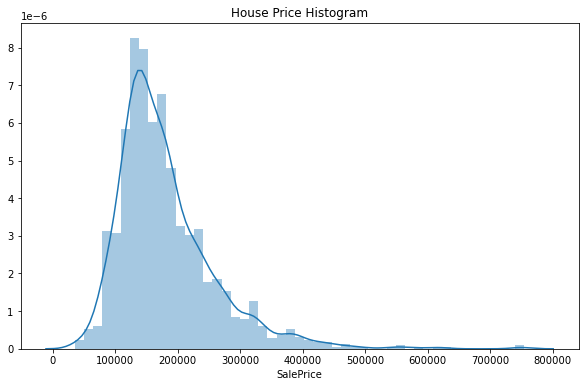

In [5]:
plt.figure(figsize=(10,6))
sns.distplot(data_train.loc[:, 'SalePrice'],kde=True)
plt.title('House Price Histogram');

## Data Cleaning & Manipulation

Para validar cual será el tratamiendo de los valores nulos, calculemos el total de estos por columnas:

In [6]:
data_train.isnull().sum()[data_train.isnull().sum()!=0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

Eliminamos las columnas que no nos están proporcionando información

In [7]:
data_train1=data_train.drop(['Alley','PoolQC','Fence','MiscFeature'],axis=1)

De la data se puede inferir que que FireplaceQu depende de Fireplaces, revisemos si podemos llenar los Nan con 0

In [8]:
data_train1[data_train1['FireplaceQu'].isnull()][['Fireplaces','FireplaceQu']].head(3)

,Fireplaces,FireplaceQu
0,0,NaN
5,0,NaN
10,0,NaN


Llenamos los NaN con NA para indicar que no existe Fireplaces en el hogar

In [9]:
data_train1['FireplaceQu']=data_train1['FireplaceQu'].fillna('NA')

Revisemos las columnas que están relacionadas con Basement

In [10]:
data_train1[data_train1['BsmtExposure'].isnull()][['BsmtQual','BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1','BsmtFinType2']].head(3)

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2
17,NaN,NaN,NaN,NaN,0,NaN
39,NaN,NaN,NaN,NaN,0,NaN
90,NaN,NaN,NaN,NaN,0,NaN


También podemos llenarlas con la etiqueta "NA" (referente a que el inmueble no cuenta con basement)

In [11]:
basement_columns=['BsmtQual','BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1','BsmtFinType2']
for column in basement_columns:
    data_train1[column]= np.where(data_train1['BsmtQual'].isnull()==False,'Av',data_train1[column].fillna('NA'))

Limpiemos ahora las columnas relacionadas con el Garage

In [12]:
data_train1[data_train1['GarageType'].isnull()][['GarageType','GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual','GarageCond']].head(3)

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
39,NaN,NaN,NaN,0,0,NaN,NaN
48,NaN,NaN,NaN,0,0,NaN,NaN
78,NaN,NaN,NaN,0,0,NaN,NaN


Similar al caso anterior podemos llenarlas con la etiqueta "NA"

In [13]:
garage_columns=['GarageType','GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual','GarageCond']
for column in garage_columns:
    data_train1[column]= data_train1[column].fillna('NA')

Para las columnas del Masonry Veneer hay que considerar las etiquetas que incluye la base:

In [14]:
data_train1[data_train1['MasVnrType'].isnull()][['MasVnrType','MasVnrArea']].head(3)

,MasVnrType,MasVnrArea
234,NaN,NaN
529,NaN,NaN
650,NaN,NaN


In [15]:
data_train1['MasVnrType']=data_train1['MasVnrType'].fillna('None')
data_train1['MasVnrArea']=data_train1['MasVnrArea'].fillna(0)

Ya que no podríamos determinar con exactitud el frente de la casa, decidí rellenar los NA's con la media de los registros 
y prorratearla con el costo. 

In [16]:
data_train1['LotFrontage']=data_train1['LotFrontage'].fillna(round(70*((data_train1['SalePrice']/180921)),0))
data_train1['Electrical']=data_train1['Electrical'].fillna('Mix')

Convertimos a formato string las variables que no deben considerarse de forma numérica:

In [17]:
data_train1['MSSubClass'] = data_train1['MSSubClass'].apply(str)
data_train1['MoSold'] = data_train1['MoSold'].astype(str)
data_train1['YrSold'] = data_train1['YrSold'].astype(str)

Veamos, ahora que variables sí tienen impacto con el precio del inmueble:

In [18]:
correlacion=data_train1.corr()["SalePrice"].abs().sort_values(ascending = False).reset_index()
correlacion[1:]

,index,SalePrice
1,OverallQual,0.790982
2,GrLivArea,0.708624
3,GarageCars,0.640409
4,GarageArea,0.623431
5,TotalBsmtSF,0.613581
6,1stFlrSF,0.605852
7,FullBath,0.560664
8,TotRmsAbvGrd,0.533723
9,YearBuilt,0.522897
10,YearRemodAdd,0.507101


Podemos ver que la gran mayoría no tiene una buena relación lineal con el precio pero para efecto de este proyecto decidí mantener las variables que expliquen al menos el 40% el comportamiento del precio

In [19]:
data=data_train1[correlacion[correlacion['SalePrice']>.3]['index'].to_list()]
data.head(3)

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,MasVnrArea,Fireplaces,LotFrontage,WoodDeckSF,2ndFlrSF,OpenPorchSF
0,208500,7,1710,2,548,856,856,2,8,2003,2003,196.0,0,65.0,0,854,61
1,181500,6,1262,2,460,1262,1262,2,6,1976,1976,0.0,1,80.0,298,0,0
2,223500,7,1786,2,608,920,920,2,6,2001,2002,162.0,1,68.0,0,866,42


De manera gráfica podemos verlo como sigue en la primer fila:

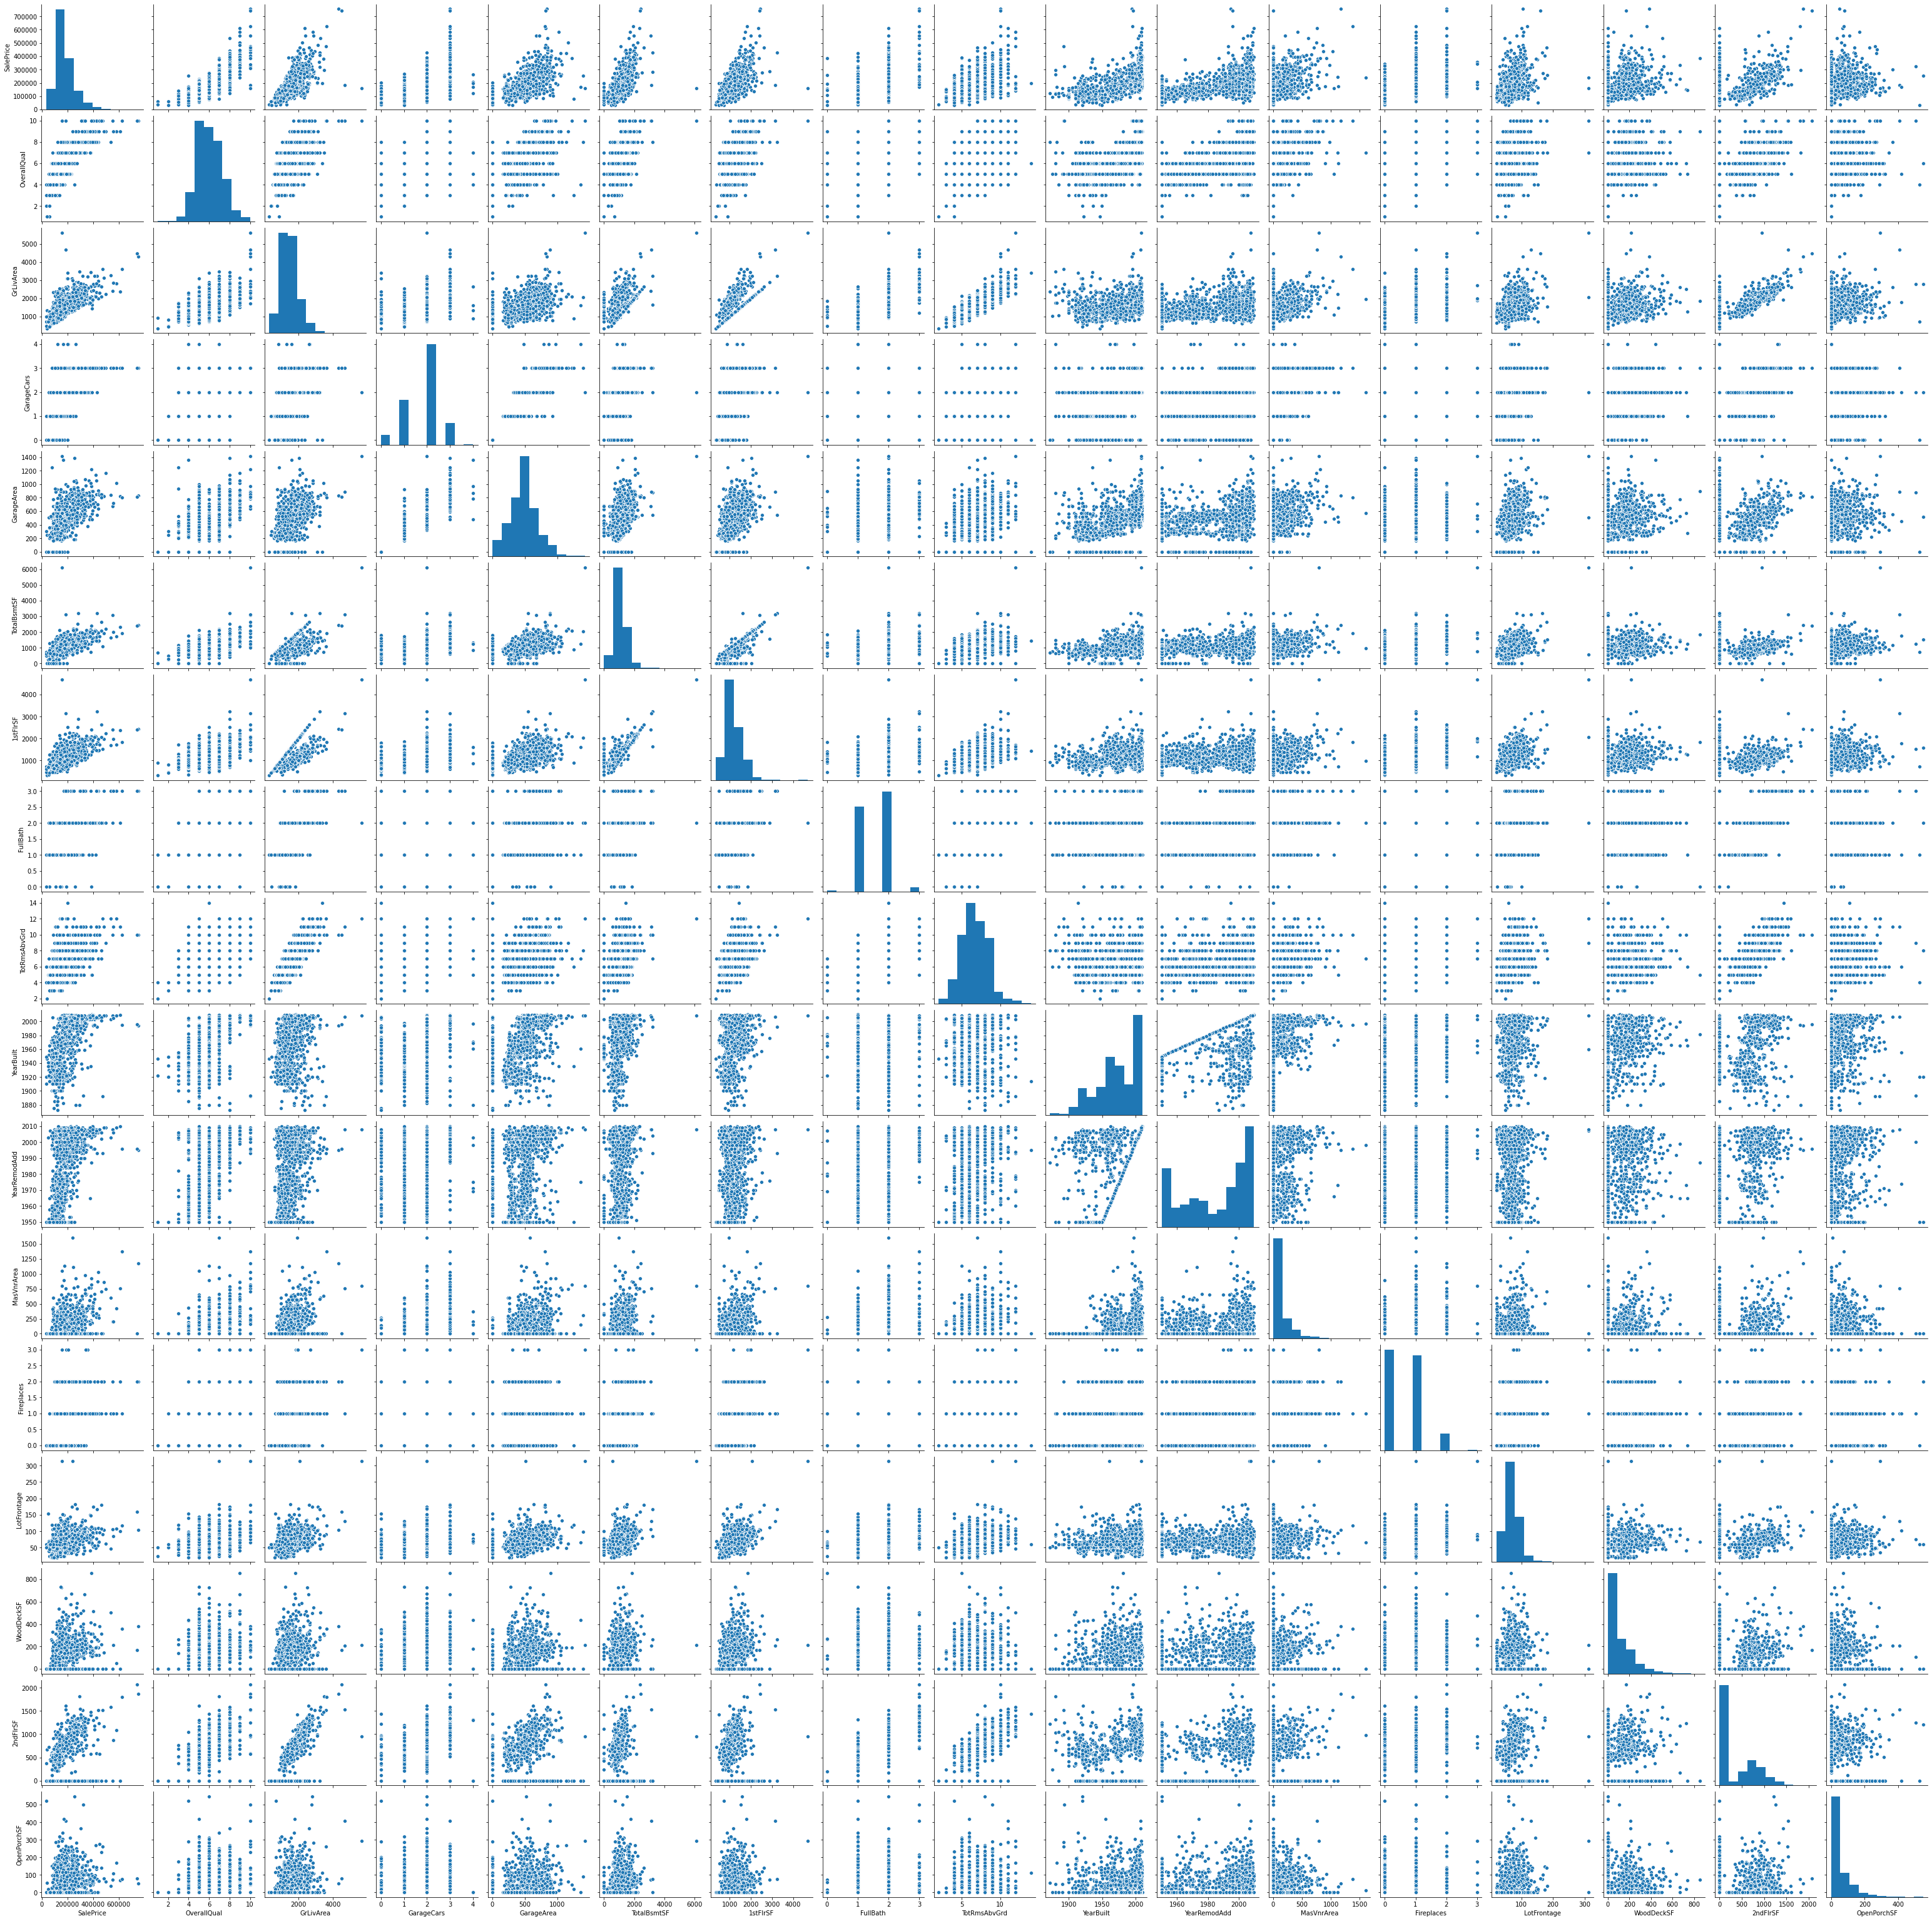

In [20]:
sns.pairplot(data=data);

## Fitting & Prediction Models

In [21]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn import metrics
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

### - Stats OLS

Definimos las variables a analizar

In [22]:
y = data['SalePrice'].reset_index(drop = True)
x = data.drop('SalePrice',axis=1)

Entrenamos el modelo y corremos la regresión

In [23]:
model = sm.OLS(y, x).fit()
predictions = data['SalePrice'] 
print_model = model.summary()
print(print_model)

                                 OLS Regression Results                                
Dep. Variable:              SalePrice   R-squared (uncentered):                   0.964
Model:                            OLS   Adj. R-squared (uncentered):              0.963
Method:                 Least Squares   F-statistic:                              2383.
Date:                Thu, 28 Jan 2021   Prob (F-statistic):                        0.00
Time:                        23:56:56   Log-Likelihood:                         -17458.
No. Observations:                1460   AIC:                                  3.495e+04
Df Residuals:                    1444   BIC:                                  3.503e+04
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

Apoyandonos en la significancia de algunas variables es posible que podemos conseguir un mejor modelo 

Aún así podemos realizar la predicción y observar como se comporta vs la data original:

In [24]:
ypred = model.predict(x)
coeff_ols=model.params
train_score=model.rsquared

# MAE & AIC 
MAE_ols=metrics.mean_absolute_error(y,ypred).round(2)
AIC_ols=model.aic.round(2)

# Aún así veamos como se comportan los valores que se predijeron:
df_pred=pd.DataFrame({'Actual':y,'Predicted':ypred,'Dif':ypred-y})
df_pred

,Actual,Predicted,Dif
0,208500,200143.741716,-8356.258284
1,181500,188766.271051,7266.271051
2,223500,212267.269347,-11232.730653
3,140000,210302.649734,70302.649734
4,250000,287571.273157,37571.273157
...,...,...,...
1455,175000,177534.753489,2534.753489
1456,210000,242189.010464,32189.010464
1457,266500,221535.731072,-44964.268928
1458,142125,130006.088435,-12118.911565


Tomamos una muestra del 20% para ver gráficamente la predicción:

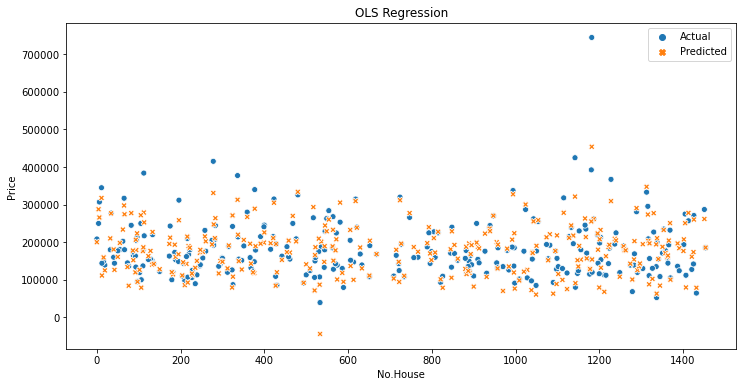

In [38]:
df_pred_20=df_pred.sample(frac=.2)

plt.figure(figsize=(12,6))
sns.scatterplot(data=df_pred_20.drop('Dif',axis=1),palette="tab10",sizes=(15,20))
plt.title('OLS Regression')
plt.xlabel('No.House')
plt.ylabel('Price');

### - sklearn LinearRegression

Primero construimos una función que nos ayude a calcular el AIC para estos modelos.

In [26]:
def calculate_aic(n, mse, num_params):
    aic = n * log(mse) + 2 * num_params
    return aic

Establecemos el tamaño de la muestra para la prueba, yo decidí continuar con la regla **80%-20%**

In [27]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.2)

Importamos y calculamos el modelo:

In [28]:
linreg= LinearRegression()
linreg.fit(x_train,y_train)

LinearRegression()

Observamos como se comportan los valores de la predicción vs los reales:

In [29]:
predicted=linreg.predict(x_test)
df_pred_LR=pd.DataFrame({'Actual':y_test,'Predicted':predicted,'Dif':predicted-y_test})
df_pred_LR

,Actual,Predicted,Dif
1263,180500,164472.806710,-16027.193290
232,94500,132739.055472,38239.055472
24,154000,149777.154937,-4222.845063
260,176000,192949.457694,16949.457694
1058,335000,299350.162548,-35649.837452
...,...,...,...
434,81000,53766.349716,-27233.650284
16,149000,157031.321861,8031.321861
587,137000,120947.792468,-16052.207532
820,183000,197719.167705,14719.167705


Calculamos los parámetros que nos interesan y gráficamos la predicción

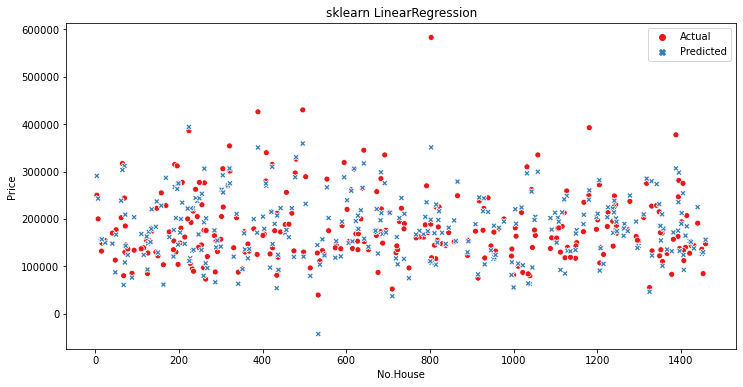

In [39]:
# Coeficiente de determinación R^2
train_score_LR = linreg.score(x_train,y_train)
test_score_LR = linreg.score(x_test,y_test)

# MAE 
MAE_LR=metrics.mean_absolute_error(y_test,predicted).round(2)

num_params = len(linreg.coef_) + 1

# MSE
mse = metrics.mean_squared_error(y_test, predicted)

# AIC
AIC_LR = calculate_aic(len(y), mse, num_params)

# Gráfica
plt.figure(figsize=(12,6))
sns.scatterplot(data=df_pred_LR.drop('Dif',axis=1),palette="Set1",sizes=(15,20))
plt.title('sklearn LinearRegression')
plt.xlabel('No.House')
plt.ylabel('Price');

### - Ridge Regression

Sabemos que por default, la regresión se calcula con un alpha de .01

In [31]:
rr = Ridge()
rr.fit(x_train,y_train)

Ridge()

Pero podemos cambiar al parametro para buscar mejores resultados

In [32]:
rr100 = Ridge(alpha=100)
rr100.fit(x_train,y_train)


Ridge(alpha=100)

Realizamos la predicción y visualizamos la tabla conjunta:

In [33]:
predicted_ridge = rr.predict(x_test)
predicted_ridge100 = rr100.predict(x_test)

df_predic_ridge = pd.DataFrame({'Actual':y_test, 'Pred_01':predicted_ridge,'Dif_01':predicted_ridge-y_test,'Pred_100':predicted_ridge100,'Dif_100':predicted_ridge100-y_test})
df_predic_ridge

,Actual,Pred_01,Dif_01,Pred_100,Dif_100
1263,180500,164419.641906,-16080.358094,160625.602957,-19874.397043
232,94500,132732.829968,38232.829968,131406.043084,36906.043084
24,154000,149787.072525,-4212.927475,150533.992454,-3466.007546
260,176000,193007.224686,17007.224686,196000.656348,20000.656348
1058,335000,299315.225776,-35684.774224,296294.438918,-38705.561082
...,...,...,...,...,...
434,81000,53814.170021,-27185.829979,57035.790308,-23964.209692
16,149000,156984.390171,7984.390171,153675.444129,4675.444129
587,137000,120942.144819,-16057.855181,121159.240492,-15840.759508
820,183000,197747.855494,14747.855494,199482.903087,16482.903087


Calculamos los parámetros que nos interesan y gráficamos la predicción

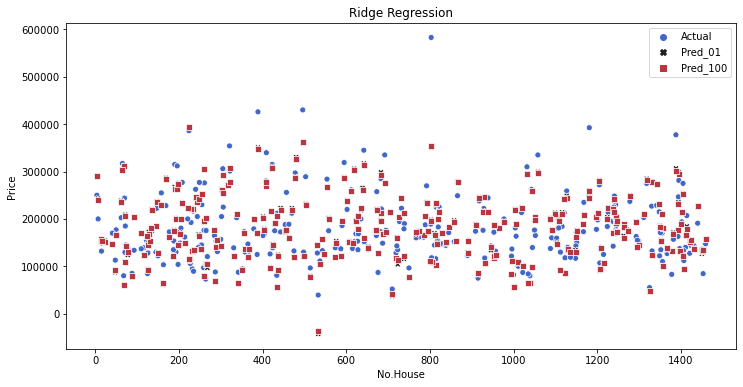

In [40]:
# R^2 
ridge_train_score = rr.score(x_train,y_train)
ridge_test_score = rr.score(x_test,y_test)
ridge_train_score100 = rr100.score(x_train,y_train)
ridge_test_score100 = rr100.score(x_test,y_test)

# MAE
MAE_Ridge_1=metrics.mean_absolute_error(y_test,predicted_ridge)
MAE_Ridge_100=metrics.mean_absolute_error(y_test,predicted_ridge100)

num_params = len(linreg.coef_) + 1

# MSE
mse = metrics.mean_squared_error(y_test, predicted_ridge)
mse100 = metrics.mean_squared_error(y_test, predicted_ridge100)
# AIC
AIC_R1 = calculate_aic(len(y), mse, num_params)
AIC_R100 = calculate_aic(len(y), mse100, num_params)

# Gráfica
plt.figure(figsize=(12,6))
sns.scatterplot(data=df_predic_ridge.drop(['Dif_01','Dif_100'],axis=1),palette="icefire")
plt.title('Ridge Regression')
plt.xlabel('No.House')
plt.ylabel('Price');

## Best Model

Podemos comparar los parámetros que nos arrojaron los 4 procesos graficamos como sigue: 

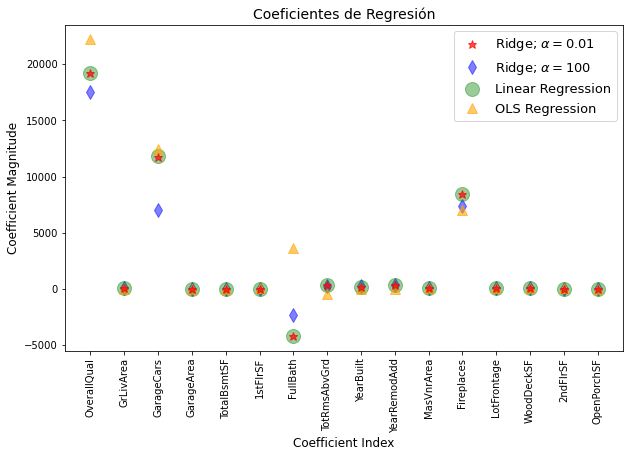

In [35]:
fig = plt.figure(facecolor='w',figsize=(10, 6))

#Gráfica de los coeficientes de Ridge con Alpha de 1
plt.plot(rr.coef_,alpha=0.7,linestyle='none',marker='*',markersize=9, color='red',label=r'Ridge; $\alpha = 0.01$',zorder=7)

#Gráfica de los coeficientes de Ridge con Alpha de 100
plt.plot(rr100.coef_,alpha=0.5,linestyle='none',marker='d',markersize=10, color='blue',label=r'Ridge; $\alpha = 100$')

#Gráfica de los coeficientes de Regresión lineal
plt.plot(linreg.coef_,alpha=0.4,linestyle='none',marker='o',markersize=14, color='green',label='Linear Regression')

#Gráfica de los coeficientes de OLS
plt.plot(model.params,alpha=0.6,linestyle='none',marker='^',markersize=10, color='orange',label=r'OLS Regression')

plt.xticks(rotation=90)
plt.xlabel('Coefficient Index',fontsize=12)
plt.ylabel('Coefficient Magnitude',fontsize=12)
plt.legend(fontsize=13,loc=1)
plt.title('Coeficientes de Regresión',fontsize=14)
plt.show()

Observamos que los de la LR de sklearn y la versión de Ridge con alfa inicial nos arrojaron casi los mismos valores, en cambio la versión de OLS es la que tiene mayor variación los demás parámetros. 

<p> Para decidir que modelo se ajusta mejor a nuestra data, podemos revisar los estadísticos: <br>

In [36]:
r2_test='-',test_score_LR,ridge_test_score,ridge_test_score100
r2_train=train_score,train_score_LR,ridge_train_score,ridge_train_score100
AICS=AIC_ols,AIC_LR,AIC_R1,AIC_R100
MAES=MAE_ols,MAE_LR,MAE_Ridge_1,MAE_Ridge_100

pd.DataFrame([r2_test,r2_train,AICS,MAES],columns=['OLS','LinearRegression','Ridge_01','Ridge_100'],index=['R2 Test','R2 Train','AIC','MAE'])

,OLS,LinearRegression,Ridge_01,Ridge_100
R2 Test,-,0.811162,0.811253,0.816349
R2 Train,0.963514,0.780333,0.780333,0.779336
AIC,34947.7,30242.960022,30242.257442,30202.295874
MAE,24099.4,22017.830000,22009.657950,21481.125495


Inicialmente podríamos pensar que el OLS es el mejor método por tener un mayor R^2, sin embargo también cuenta con el MAE y el AIC más grande por lo que los datos sugieren que el modelo tiene errores.

De los modelos restantes podemos observar una diferencia entre los valores del R^2 del train y test por lo que es probable que tengamos underfitting, aún así los valores son buenos. 

Entre estos 4 tendríamos que elegir el **Ridge con alpha de 100** pues tiene los AIC y MAE menores.